In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [21]:
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.12.0


## Prepare Dataset

In [104]:
# train_dataset_path = './dataset/dataset-raw-asli/train_preprocess.tsv'
# valid_dataset_path = './dataset/dataset-raw-asli/valid_preprocess.tsv'

train_dataset_path = 'Dataset/Training/Clean_train_data_nostem.csv'
# valid_dataset_path = './dataset-emosi/valid_preprocess.csv'

In [107]:
# train_df = pd.read_csv(train_dataset_path, sep='\t', header=None)
# valid_df = pd.read_csv(valid_dataset_path, sep='\t', header=None)

# train_df.columns = ['text', 'label']
# valid_df.columns = ['text', 'label']

train_df = pd.read_csv(train_dataset_path, sep=',', header=None, usecols=[1,2], skiprows=1)
# valid_df = pd.read_csv(valid_dataset_path, sep=',', header=None, usecols=[0,1], skiprows=1)

train_df.columns = ['tweet', 'label']
# valid_df.columns = ['label', 'tweet']

In [108]:
train_df.head(10)

,tweet,label
0,"['pagi', 'emosi']",Anger
1,"['stabilitas', 'negara', 'memange', 'tahun', '...",Anger
2,"['emosi', 'liat']",Anger
3,"['aib', 'bodoh', 'aib', 'muncul', 'tindakan', ...",Anger
4,"['menyebalkan', 'bodoh']",Anger
5,"['asli', 'malu', 'maluin', 'indo', 'tolol', 'r...",Anger
6,"['drama', 'abg', 'tolol']",Anger
7,"['emosi', 'katla', 'kemarin', 'keterangannya',...",Anger
8,"['bangsat', 'tribute', 'no', 'bencana', 'no', ...",Anger
9,"['pergi', 'teriak', 'nangis', 'sekencang', 'ke...",Anger


In [111]:
train_df['label']

0       Anger
1       Anger
2       Anger
3       Anger
4       Anger
        ...  
7075      Sad
7076      Sad
7077      Sad
7078      Sad
7079      Sad
Name: label, Length: 7080, dtype: object

In [112]:
def get_label_idx(label):
    if label == 'Anger':
        return 0
    if label == 'Joy':
        return 1
    if label == 'Fear':
        return 2
    if label == "Love":
        return 3
    if label == "Sad":
        return 4
    if label == "Neutral":
        return 5

train_df['label'] = train_df['label'].apply(get_label_idx)
# valid_df['label'] = valid_df['label'].apply(get_label_idx)


In [131]:
unique_labels = train_df['label'].unique()
print(unique_labels)


[4 3 1 0 2]


In [113]:
train_df

,tweet,label
0,"['pagi', 'emosi']",0
1,"['stabilitas', 'negara', 'memange', 'tahun', '...",0
2,"['emosi', 'liat']",0
3,"['aib', 'bodoh', 'aib', 'muncul', 'tindakan', ...",0
4,"['menyebalkan', 'bodoh']",0
...,...,...
7075,"['pagi', 'seisi', 'semesta', 'sujud', 'zat', '...",4
7076,"['engkau', 'pergi', 'engkau', 'meninggalkan', ...",4
7077,"['kalah', 'tersakiti']",4
7078,"['apakabar', 'ku', 'fikiranku', 'menentu']",4


In [114]:
# filter dataset yang labelnya 0-4 aja
train_df = train_df[train_df['label'] < 5]
# valid_df = valid_df[valid_df['label'] < 5]

In [115]:
train_df['label'].value_counts()

label
1    1275
0    1130
4    1003
2     911
3     760
Name: count, dtype: int64

In [116]:
# join list of token as single document string
import ast

def join_text_list(texts):
    texts = ast.literal_eval(texts)
    return ' '.join([text for text in texts])
train_df["preprocessed"] = train_df["tweet"].apply(join_text_list)
# valid_df["preprocessed"] = valid_df["tweet_tokens_no_stemming"].apply(join_text_list)

train_df["preprocessed"].head()

C:\Users\Codelabs\AppData\Local\Temp\ipykernel_20976\4119128493.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["preprocessed"] = train_df["tweet"].apply(join_text_list)


0                                           pagi emosi
1    stabilitas negara memange tahun negara aman sb...
2                                           emosi liat
3    aib bodoh aib muncul tindakan kekejian sembuny...
4                                    menyebalkan bodoh
Name: preprocessed, dtype: object

## Generate Padded Sequence

In [117]:
# Parameters

vocab_size = 20000 #ukuran kosakata yang akan digunakan
max_length = 100 #panjang maksimal dari sebuah kalimat
embedding_dim = 8 #dimensi vektor embedding yang akan digunakan
trunc_type='post' #jika panjang kalimat melebihi max_length, potong bagian belakang kalimat
oov_tok = "<OOV>" #OOV (Out Of Vocabulary) token, jika suatu kata tidak ditemukan dalam kosakata

In [118]:
from sklearn.model_selection import train_test_split

# Bagi dataset menjadi data pelatihan dan data validasi
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Inisialisasi tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate word index dictionary untuk kalimat-kalimat pelatihan
tokenizer.fit_on_texts(train_df['preprocessed'])
word_index = tokenizer.word_index
print(word_index)

# Convert kalimat-kalimat pelatihan menjadi urutan kata
train_sequences = tokenizer.texts_to_sequences(train_df['preprocessed'])
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type)

# Convert kalimat-kalimat validasi menjadi urutan kata
valid_sequences = tokenizer.texts_to_sequences(valid_df['preprocessed'])
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, truncating=trunc_type)


{'<OOV>': 1, 'suka': 2, 'sedih': 3, 'semangat': 4, 'takut': 5, 'pagi': 6, 'marah': 7, 'bodoh': 8, 'bikin': 9, 'malu': 10, 'tuh': 11, 'sayang': 12, 'si': 13, 'cinta': 14, 'pas': 15, 'bahagia': 16, 'emosi': 17, 'kasih': 18, 'wkwk': 19, 'pakai': 20, 'semoga': 21, 'anak': 22, 'kaget': 23, 'liat': 24, 'yaa': 25, 'kabar': 26, 'tolol': 27, 'kak': 28, 'teman': 29, 'ku': 30, 'sepi': 31, 'benci': 32, 'iya': 33, 'senang': 34, 'ngeri': 35, 'kek': 36, 'nangis': 37, 'kecewa': 38, 'kadang': 39, 'baca': 40, 'gini': 41, 'deh': 42, 'bangsat': 43, 'kaya': 44, 'lupa': 45, 'salah': 46, 'biar': 47, 'gimana': 48, 'sakit': 49, 'bilang': 50, 'makan': 51, 'bangun': 52, 'sehat': 53, 'lagu': 54, 'kemarin': 55, 'nonton': 56, 'kesal': 57, 'tidur': 58, 'alhamdulillah': 59, 'bagus': 60, 'happy': 61, 'allah': 62, 'denise': 63, 'waktu': 64, 'beli': 65, 'hati': 66, 'lucu': 67, 'you': 68, 'eh': 69, 'rumah': 70, 'cowok': 71, 'panik': 72, 'haha': 73, 'jimin': 74, 'cewek': 75, 'bicara': 76, 'selamat': 77, 'diam': 78, 'main'

In [32]:
# ## Tokenization
# tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# # Generate word index dictionary for the training sentences
# tokenizer.fit_on_texts(train_df['preprocessed'])
# word_index = tokenizer.word_index
# print(word_index)

# # Convert the training sentences into word sequences
# train_sequences = tokenizer.texts_to_sequences(train_df['preprocessed'])
# train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type)

# # Convert the validation sentences into word sequences
# valid_sequences = tokenizer.texts_to_sequences(valid_df['tweet'])
# valid_padded = pad_sequences(valid_sequences, maxlen=max_length, truncating=trunc_type)

In [33]:
# Split Dataset


In [34]:
# import pickle

# # Simpan tokenizer ke dalam file
# with open('tokenizer-3classes-no-stemming.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [119]:
print(train_padded[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   3  83 377 767]


## Word Embedding

In [120]:
from gensim.models import Word2Vec

sentences = [sentence.split() for sentence in train_df['preprocessed']]
w2v_model = Word2Vec(sentences, vector_size=8, window=5, min_count=5, workers=4)

In [121]:
# Create a weight matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size, 8))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [122]:
# Mencari kata berdasarkan vektor tertentu
def find_word_by_vector(embedding_matrix, vector):
    for word, index in word_index.items():
        if np.array_equal(embedding_matrix[index], vector):
            return word, embedding_matrix[index]
    return None

# Contoh: Mencari kata untuk vektor embedding_matrix[3]
word = find_word_by_vector(embedding_matrix, embedding_matrix[1000])
print(word)

('part', array([-0.05028091, -0.09066646,  0.21042402,  0.02811795,  0.11097754,
       -0.03235529,  0.26397732, -0.17149228]))


## Build and Compile Model

In [145]:


model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 8, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), input_shape=(max_length,), trainable=False),
    # tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 100, 8)            160000    
                                                                 
 dense_51 (Dense)            (None, 100, 256)          2304      
                                                                 
 dropout_26 (Dropout)        (None, 100, 256)          0         
                                                                 
 dense_52 (Dense)            (None, 100, 128)          32896     
                                                                 
 dropout_27 (Dropout)        (None, 100, 128)          0         
                                                                 
 dense_53 (Dense)            (None, 100, 64)           8256      
                                                                 
 flatten_8 (Flatten)         (None, 6400)            

In [51]:
# Looping untuk mendapatkan bobot dari setiap layer
for layer in model.layers:
    # Mengecek apakah layer memiliki bobot
    if layer.weights:
        print("Layer Name:", layer.name)
        # Mendapatkan bobot dan bias dari layer
        weights = layer.get_weights()
        for i, w in enumerate(weights):
            print("Weights Shape (Tensor {}):".format(i), w.shape)
            print("Weights (Tensor {}):".format(i))
            print(w)


Layer Name: embedding_2
Weights Shape (Tensor 0): (20000, 8)
Weights (Tensor 0):
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.9957197  -0.6584918   1.7150434  ... -1.4374956   3.7385106
  -0.05180896]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
Layer Name: dense_4
Weights Shape (Tensor 0): (8, 256)
Weights (Tensor 0):
[[-0.0910463  -0.04208025  0.04422048 ...  0.12461621 -0.05251758
  -0.06434299]
 [ 0.01475778  0.13518164  0.08280908 ...  0.14844105 -0.13490623
   0.09771566]
 [ 0.09419091  0.13574997 -0.08973446 ... -0.10085122 -0.00273953
  -0.1150976 ]
 ...
 [-0.07112589  0.09102079  0.13204521 ...  0.10315853 -0.05760739
   0.11614862]
 [-0.11782937 -0.03599309  0.13623866 ... -0.09157258  0.0616467

## Train Model

In [146]:
num_epochs = 50

history = model.fit(train_padded, train_df['label'], epochs=num_epochs, validation_data=(valid_padded, valid_df['label']), verbose=2)


Epoch 1/50
127/127 - 4s - loss: 1.5883 - accuracy: 0.2446 - val_loss: 1.5781 - val_accuracy: 0.2539 - 4s/epoch - 28ms/step
Epoch 2/50
127/127 - 3s - loss: 1.5665 - accuracy: 0.2715 - val_loss: 1.5548 - val_accuracy: 0.2874 - 3s/epoch - 20ms/step
Epoch 3/50
127/127 - 3s - loss: 1.5422 - accuracy: 0.2978 - val_loss: 1.5266 - val_accuracy: 0.2904 - 3s/epoch - 21ms/step
Epoch 4/50
127/127 - 3s - loss: 1.4899 - accuracy: 0.3328 - val_loss: 1.4985 - val_accuracy: 0.2736 - 3s/epoch - 21ms/step
Epoch 5/50
127/127 - 3s - loss: 1.4155 - accuracy: 0.3844 - val_loss: 1.3875 - val_accuracy: 0.4094 - 3s/epoch - 20ms/step
Epoch 6/50
127/127 - 3s - loss: 1.3711 - accuracy: 0.4295 - val_loss: 1.3982 - val_accuracy: 0.3711 - 3s/epoch - 21ms/step
Epoch 7/50
127/127 - 3s - loss: 1.3134 - accuracy: 0.4580 - val_loss: 1.3907 - val_accuracy: 0.3907 - 3s/epoch - 20ms/step
Epoch 8/50
127/127 - 2s - loss: 1.2653 - accuracy: 0.4915 - val_loss: 1.2422 - val_accuracy: 0.5246 - 2s/epoch - 20ms/step
Epoch 9/50
127/1

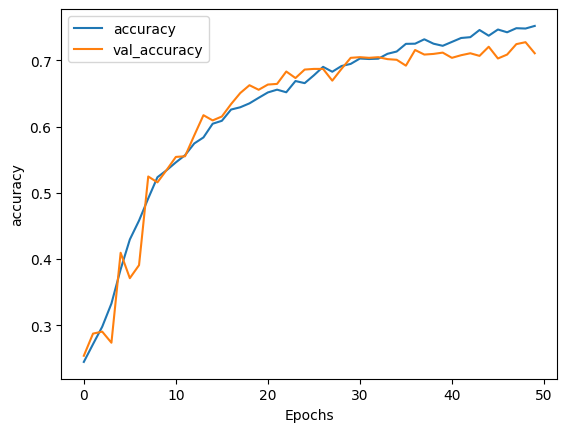

In [147]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")

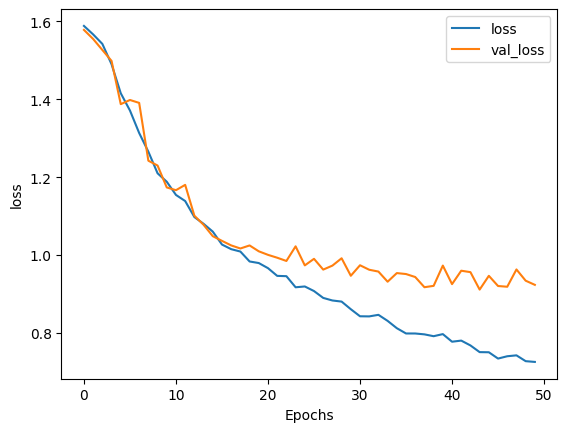

In [148]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "loss")

In [149]:
# saved model
model.save('model-5classes-no-stemming-ANN.h5')

In [150]:
## test model with predict one example sentence
sample_text = ["aduh gimana ya ini takut"]
sample_seq = tokenizer.texts_to_sequences(sample_text)
sample_padded = pad_sequences(sample_seq, maxlen=max_length, truncating=trunc_type)
print(model.predict(sample_padded))

## convert predict to label
def get_label(predict):
    if predict == 0:
        return 'Anger'
    if predict == 1:
        return 'Joy'
    if predict == 2:
        return 'Fear'
    if predict == 3:
        return 'Love'
    if predict == 4:
        return 'Sad'
    # if predict == 5:
    #     return 'Neutral'
    
    
print(get_label(np.argmax(model.predict(sample_padded))))    



1/1 [==============================] - 0s 113ms/step
[[4.0949791e-04 9.8773406e-04 9.9626887e-01 1.7899529e-03 5.4394506e-04]]
1/1 [==============================] - 0s 21ms/step
Fear


In [151]:
from sklearn.metrics import classification_report

# Melakukan prediksi pada data uji
y_pred = model.predict(valid_padded)
y_pred_classes = np.argmax(y_pred, axis=1)

print (y_pred_classes.shape)
print (y_pred.shape)

# Mencetak classification report
print(classification_report(valid_df["label"], y_pred_classes))

32/32 [==============================] - 0s 5ms/step
(1016,)
(1016, 5)
              precision    recall  f1-score   support

           0       0.62      0.78      0.69       245
           1       0.76      0.67      0.71       257
           2       0.76      0.72      0.74       174
           3       0.64      0.73      0.68       139
           4       0.83      0.65      0.73       201

    accuracy                           0.71      1016
   macro avg       0.72      0.71      0.71      1016
weighted avg       0.73      0.71      0.71      1016



In [47]:
#save model
model.save('./model/model-LSTM-word2vec-3-classes-no-stemming.h5')

In [48]:
import numpy as np
import tensorflow as tf

# Inisialisasi bobot kernel dengan ukuran 5
kernel_size = 5
num_filters = 1
embedding_dim = 8

# Membuat bobot kernel dengan inisialisasi Glorot uniform
initializer = tf.keras.initializers.GlorotUniform()
kernel_weights = initializer(shape=(kernel_size, embedding_dim, num_filters))

# Dibulatkan ke angka terdekat
kernel_weights_rounded = np.round(kernel_weights, decimals=2)

print("Bobot kernel dengan inisialisasi Glorot uniform (dibulatkan):")
print(kernel_weights_rounded)
print("Shape bobot kernel:", kernel_weights.shape)


Bobot kernel dengan inisialisasi Glorot uniform (dibulatkan):
[[[ 0.18]
  [-0.26]
  [ 0.01]
  [-0.15]
  [ 0.11]
  [ 0.05]
  [ 0.01]
  [ 0.25]]

 [[ 0.15]
  [-0.36]
  [-0.  ]
  [ 0.03]
  [-0.01]
  [-0.28]
  [-0.1 ]
  [-0.09]]

 [[-0.02]
  [ 0.22]
  [-0.07]
  [ 0.26]
  [ 0.28]
  [ 0.17]
  [ 0.04]
  [ 0.29]]

 [[ 0.28]
  [ 0.26]
  [ 0.17]
  [-0.11]
  [-0.22]
  [-0.17]
  [ 0.05]
  [ 0.06]]

 [[-0.07]
  [ 0.11]
  [-0.26]
  [ 0.29]
  [-0.28]
  [ 0.17]
  [ 0.12]
  [-0.13]]]
Shape bobot kernel: (5, 8, 1)
